In [205]:
import xgboost as xgb
import numpy as np
import pandas as pd
import time
import pickle
import os
from math import log
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, ParameterGrid,StratifiedKFold, cross_val_score

from sklearn import metrics 
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score, brier_score_loss, f1_score, log_loss,auc,roc_curve,auc

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.decomposition import PCA
#from sklearn.utils.fixes import signature

from datetime import datetime

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [206]:
import os 
os.chdir(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\RGS")

In [207]:
df = pd.concat([pd.read_csv(os.getcwd()+r"\Data Files\segment dump.csv"),
                  pd.read_csv(os.getcwd()+r"\Data Files\segment dump1.csv"),
                  pd.read_csv(os.getcwd()+r"\Data Files\segment dump2.csv")])

In [208]:
df.head()

,SKP_CREDIT_CASE,TIME_CREATION_DATE,PRODUCT_GOODS_TYPE,PRODUCT_CREDIT_TYPE,AMT_CREDIT,POS_GSPN_V2,SCORE_APSC_NOV18,DECISION_OVERALL,RISK_AGRF30,RISK_FPD30,RISK_FSTQPD30,RISK_FSTQPD60,SEGMENT
0,220543583,01-01-19,c_Mob_Tab,ZERO,4035.0,2.0,NaN,Cancelled,0,0,0,0,Goodtohave
1,220543586,01-01-19,c_Mob_Tab,STANDARD,7699.0,2.0,0.020487,Approved,1,0,0,0,Goodtohave
2,220543587,01-01-19,c_Mob_Tab,ZERO,7961.0,2.0,0.011752,Approved,1,0,0,0,Desirable
3,220543588,01-01-19,c_Mob_Tab,2X0,7500.0,1.0,0.008070,Approved,1,0,0,0,Desirable
4,220543589,01-01-19,c_Mob_Tab,STANDARD,6849.0,1.0,0.013409,Approved,1,0,0,0,undesirable


In [209]:
df["TIME_CREATION_DATE"] = pd.to_datetime(df["TIME_CREATION_DATE"],format ='%d-%m-%y')
df["MONTH"]= df["TIME_CREATION_DATE"].dt.strftime("%y-%m")

In [210]:
df = df[df["DECISION_OVERALL"] == "Approved"]
df.dropna(inplace = True)

In [211]:
df_summ = df[["MONTH","RISK_FSTQPD30"]].groupby("MONTH").aggregate(["count","sum"])["RISK_FSTQPD30"]
df_summ["bad_rate"] = df_summ["sum"]/df_summ["count"]

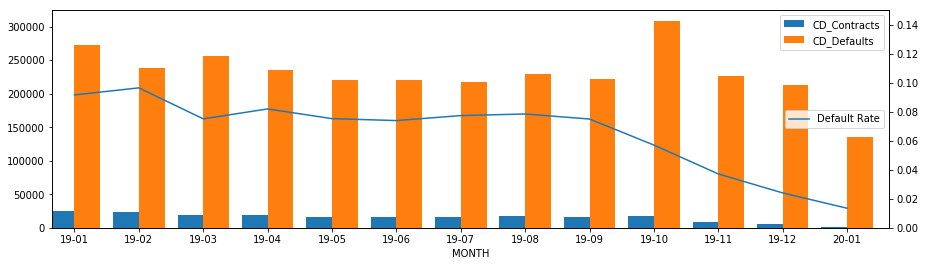

In [212]:
df_summ[['sum','count']].plot(kind='bar', width = 0.8, figsize=(15,4))
df_summ['bad_rate'].plot(secondary_y=True)

ax = plt.gca()
plt.xlim([-0.35, len(df_summ['sum'])-0.35])
ax.set_xticklabels(df_summ.index)
plt.ylim
fig = ax.get_figure()
ax = fig.get_axes()
ax[1].set_ylim(0,0.15)
ax[0].legend(['CD_Contracts','CD_Defaults'])
ax[1].legend(["Default Rate"], loc = "center right")
plt.show()

In [213]:
#One Hot Encoding
df_encoded = df
for x in ["PRODUCT_CREDIT_TYPE","POS_GSPN_V2","PRODUCT_GOODS_TYPE","SEGMENT"]:
    
    dummy = pd.get_dummies(df_encoded[x])
    dummy.columns = [str(y)+"_"+x for y in dummy.columns]
    df_encoded = pd.concat([df_encoded, dummy], axis=1)

In [214]:
df = df_encoded

In [215]:
df_test = df[df["TIME_CREATION_DATE"]>= pd.datetime(2019,5,1)]
df_train = df[df["TIME_CREATION_DATE"]< pd.datetime(2019,5,1)]

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



# Combined

In [216]:
# x_column = ['AMT_CREDIT', 'SCORE_APSC_NOV18', '2X0_PRODUCT_CREDIT_TYPE',
#        'STANDARD_PRODUCT_CREDIT_TYPE', 'ZERO_PRODUCT_CREDIT_TYPE',
#        '1.0_POS_GSPN_V2', '2.0_POS_GSPN_V2', '3.0_POS_GSPN_V2',
#        '17.0_POS_GSPN_V2', 'c_Mob_Tab_PRODUCT_GOODS_TYPE',
#        'd_CP_PRODUCT_GOODS_TYPE', 'e_HA_PRODUCT_GOODS_TYPE',
#        'Desirable_SEGMENT', 'Goodtohave_SEGMENT', 'undesirable_SEGMENT']

x_column = ['AMT_CREDIT', 'SCORE_APSC_NOV18', '2X0_PRODUCT_CREDIT_TYPE',
       'STANDARD_PRODUCT_CREDIT_TYPE', '1.0_POS_GSPN_V2', '2.0_POS_GSPN_V2', '3.0_POS_GSPN_V2',
        'c_Mob_Tab_PRODUCT_GOODS_TYPE', 'd_CP_PRODUCT_GOODS_TYPE', 'Desirable_SEGMENT', 'Goodtohave_SEGMENT']

y_column = 'RISK_FSTQPD30'

RISK_SCORE = 'SCORE_APSC_NOV18'

In [217]:
# split data into train and test sets
seed = 25522

X_test = df_test[x_column]
y_test = df_test[y_column]

X_train, X_valid, y_train, y_valid = train_test_split(df_train[x_column], df_train[y_column], test_size=0.2, random_state=seed)


##event rate
print("\nEvent rate in train set :", '{:,.2%}'.format(sum(y_train) / len(y_train)))
print("\n Train set shape:",X_train.shape)
print("\nEvent rate in test set :", '{:,.2%}'.format(sum(y_test) / len(y_test)))
print("\n Test set shape:",X_test.shape)
print("\nEvent rate in validation set :", '{:,.2%}'.format(sum(y_valid) / len(y_valid)))
print("\n validation set shape:",X_valid.shape)
print("\n Train GINI",  metrics.roc_auc_score(y_train, X_train[RISK_SCORE])*2 -1)
print("\n Test GINI",  metrics.roc_auc_score(y_test, X_test[RISK_SCORE])*2 -1)
print("\n validation GINI",  metrics.roc_auc_score(y_valid, X_valid[RISK_SCORE])*2 -1)



Event rate in train set : 8.63%

 Train set shape: (802310, 11)

Event rate in test set : 5.89%

 Test set shape: (1992238, 11)

Event rate in validation set : 8.63%

 validation set shape: (200578, 11)

 Train GINI 0.23872448807514957

 Test GINI 0.22803106439324372

 validation GINI 0.23249104815985921


## Logistic Model

## L2 Penalty Hyper Parameter Optimization

In [91]:
param_grid = {'C':np.exp(np.arange(-3,5,0.01))}

In [92]:
from sklearn.model_selection import StratifiedKFold
kfolds = StratifiedKFold(3, random_state=1)
comb=LogisticRegression(penalty = 'l1')

rcv = RandomizedSearchCV(estimator = comb, param_distributions=param_grid, scoring=['roc_auc'], n_iter = 30,
    cv=kfolds.split(X_train,y_train), verbose=0, random_state=1,
    refit = 'roc_auc', return_train_score=True, error_score = 0)

In [93]:
#Calculate Gini Lift Logistic Regression
print("Randomized search..")

search_time_start = time.time()
rcv.fit(X_train, y_train)
print("Randomized search time:", time.time() - search_time_start)
params = rcv.best_params_   #get best parameters
dic=rcv.cv_results_    #provides scoring results for each iteration, 50 in this case, mean values can be used 
tmp= pd.DataFrame(dic['params'])

Randomized search..


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_mod

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_mod

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_mod

Randomized search time: 460.1734712123871


In [94]:
tmp1= pd.DataFrame(dic)[["param_C","mean_test_roc_auc","mean_train_roc_auc"]].sort_values(by = 'param_C')

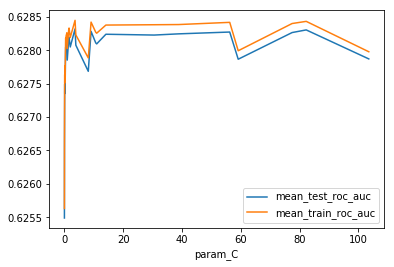

In [95]:
tmp1.plot(x="param_C")

In [96]:
params

{'C': 3.669296667618908}

## Logistic With optimized Hyperparameters 

In [218]:
from sklearn.linear_model import LogisticRegression

bst = LogisticRegression(penalty = 'l1', C=3.669296667618908)

bst.fit(X_train, y_train)

ypred_train = bst.predict_proba(X_train)[:, 1]
ypred_valid = bst.predict_proba(X_valid)[:, 1]
ypred_test = bst.predict_proba(X_test)[:, 1]

print("Train GINI %.3f" % (2*metrics.roc_auc_score(y_train, ypred_train)-1))
print("Valid GINI %.3f" % (2*metrics.roc_auc_score(y_valid, ypred_valid)-1))
print("Test GINI %.3f" % (2*metrics.roc_auc_score(y_test, ypred_test)-1))


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Train GINI 0.257
Valid GINI 0.255
Test GINI 0.225


In [219]:
print("Train GINI %.3f" % (2*metrics.roc_auc_score(y_train, X_train[RISK_SCORE])-1))
print("Valid GINI %.3f" % (2*metrics.roc_auc_score(y_valid, X_valid[RISK_SCORE])-1))
print("Test GINI %.3f" % (2*metrics.roc_auc_score(y_test,X_test[RISK_SCORE])-1))


Train GINI 0.239
Valid GINI 0.232
Test GINI 0.228


In [221]:
df["RISK_RGS_SEGMENT SCORE"] =  bst.predict_proba(df[x_column])[:, 1]

# Segment Standalone

In [222]:
# x_column = ['AMT_CREDIT', 'SCORE_APSC_NOV18', '2X0_PRODUCT_CREDIT_TYPE',
#        'STANDARD_PRODUCT_CREDIT_TYPE', 'ZERO_PRODUCT_CREDIT_TYPE',
#        '1.0_POS_GSPN_V2', '2.0_POS_GSPN_V2', '3.0_POS_GSPN_V2',
#        '17.0_POS_GSPN_V2', 'c_Mob_Tab_PRODUCT_GOODS_TYPE',
#        'd_CP_PRODUCT_GOODS_TYPE', 'e_HA_PRODUCT_GOODS_TYPE',
#        'Desirable_SEGMENT', 'Goodtohave_SEGMENT', 'undesirable_SEGMENT']

x_column = ['Desirable_SEGMENT', 'Goodtohave_SEGMENT']

y_column = 'RISK_FSTQPD30'

RISK_SCORE = 'SCORE_APSC_NOV18'

In [223]:
# split data into train and test sets
seed = 25522

X_test = df_test[x_column]
y_test = df_test[y_column]

X_train, X_valid, y_train, y_valid = train_test_split(df_train[x_column], df_train[y_column], test_size=0.2, random_state=seed)


##event rate
print("\nEvent rate in train set :", '{:,.2%}'.format(sum(y_train) / len(y_train)))
print("\n Train set shape:",X_train.shape)
print("\nEvent rate in test set :", '{:,.2%}'.format(sum(y_test) / len(y_test)))
print("\n Test set shape:",X_test.shape)
print("\nEvent rate in validation set :", '{:,.2%}'.format(sum(y_valid) / len(y_valid)))
print("\n validation set shape:",X_valid.shape)
# print("\n Train GINI",  metrics.roc_auc_score(y_train, X_train[RISK_SCORE])*2 -1)
# print("\n Test GINI",  metrics.roc_auc_score(y_test, X_test[RISK_SCORE])*2 -1)
# print("\n validation GINI",  metrics.roc_auc_score(y_valid, X_valid[RISK_SCORE])*2 -1)



Event rate in train set : 8.63%

 Train set shape: (802310, 2)

Event rate in test set : 5.89%

 Test set shape: (1992238, 2)

Event rate in validation set : 8.63%

 validation set shape: (200578, 2)


## Logistic Model

## L2 Penalty Hyper Parameter Optimization

In [102]:
param_grid = {'C':np.exp(np.arange(-3,5,0.01))}

In [103]:
from sklearn.model_selection import StratifiedKFold
kfolds = StratifiedKFold(3, random_state=1)
comb=LogisticRegression(penalty = 'l1')

rcv = RandomizedSearchCV(estimator = comb, param_distributions=param_grid, scoring=['roc_auc'], n_iter = 30,
    cv=kfolds.split(X_train,y_train), verbose=0, random_state=1,
    refit = 'roc_auc', return_train_score=True, error_score = 0)

In [104]:
#Calculate Gini Lift Logistic Regression
print("Randomized search..")

search_time_start = time.time()
rcv.fit(X_train, y_train)
print("Randomized search time:", time.time() - search_time_start)
params = rcv.best_params_   #get best parameters
dic=rcv.cv_results_    #provides scoring results for each iteration, 50 in this case, mean values can be used 
tmp= pd.DataFrame(dic['params'])

Randomized search..


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_mod

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_mod

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_mod

Randomized search time: 90.67057228088379


In [105]:
tmp1= pd.DataFrame(dic)[["param_C","mean_test_roc_auc","mean_train_roc_auc"]].sort_values(by = 'param_C')

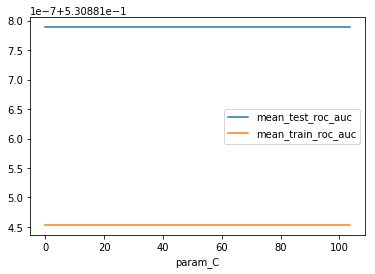

In [106]:
tmp1.plot(x="param_C")

In [107]:
params

{'C': 0.05393368730035592}

## Logistic With optimized Hyperparameters 

In [224]:
from sklearn.linear_model import LogisticRegression

bst = LogisticRegression(penalty = 'l1', C=0.05393368730035592)

bst.fit(X_train, y_train)

ypred_train = bst.predict_proba(X_train)[:, 1]
ypred_valid = bst.predict_proba(X_valid)[:, 1]
ypred_test = bst.predict_proba(X_test)[:, 1]

print("Train GINI %.3f" % (2*metrics.roc_auc_score(y_train, ypred_train)-1))
print("Valid GINI %.3f" % (2*metrics.roc_auc_score(y_valid, ypred_valid)-1))
print("Test GINI %.3f" % (2*metrics.roc_auc_score(y_test, ypred_test)-1))


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Train GINI 0.062
Valid GINI 0.072
Test GINI 0.053


In [225]:
df["SEGMENT_SCORE"] =  bst.predict_proba(df[x_column])[:, 1]

# W/O Segment

In [226]:
# x_column = ['AMT_CREDIT', 'SCORE_APSC_NOV18', '2X0_PRODUCT_CREDIT_TYPE',
#        'STANDARD_PRODUCT_CREDIT_TYPE', 'ZERO_PRODUCT_CREDIT_TYPE',
#        '1.0_POS_GSPN_V2', '2.0_POS_GSPN_V2', '3.0_POS_GSPN_V2',
#        '17.0_POS_GSPN_V2', 'c_Mob_Tab_PRODUCT_GOODS_TYPE',
#        'd_CP_PRODUCT_GOODS_TYPE', 'e_HA_PRODUCT_GOODS_TYPE',
#        'Desirable_SEGMENT', 'Goodtohave_SEGMENT', 'undesirable_SEGMENT']

x_column = ['AMT_CREDIT', 'SCORE_APSC_NOV18', '2X0_PRODUCT_CREDIT_TYPE',
       'STANDARD_PRODUCT_CREDIT_TYPE', '1.0_POS_GSPN_V2', '2.0_POS_GSPN_V2', '3.0_POS_GSPN_V2',
        'c_Mob_Tab_PRODUCT_GOODS_TYPE', 'd_CP_PRODUCT_GOODS_TYPE']

y_column = 'RISK_FSTQPD30'

RISK_SCORE = 'SCORE_APSC_NOV18'

In [227]:
# split data into train and test sets
seed = 25522

X_test = df_test[x_column]
y_test = df_test[y_column]

X_train, X_valid, y_train, y_valid = train_test_split(df_train[x_column], df_train[y_column], test_size=0.2, random_state=seed)


##event rate
print("\nEvent rate in train set :", '{:,.2%}'.format(sum(y_train) / len(y_train)))
print("\n Train set shape:",X_train.shape)
print("\nEvent rate in test set :", '{:,.2%}'.format(sum(y_test) / len(y_test)))
print("\n Test set shape:",X_test.shape)
print("\nEvent rate in validation set :", '{:,.2%}'.format(sum(y_valid) / len(y_valid)))
print("\n validation set shape:",X_valid.shape)
print("\n Train GINI",  metrics.roc_auc_score(y_train, X_train[RISK_SCORE])*2 -1)
print("\n Test GINI",  metrics.roc_auc_score(y_test, X_test[RISK_SCORE])*2 -1)
print("\n validation GINI",  metrics.roc_auc_score(y_valid, X_valid[RISK_SCORE])*2 -1)



Event rate in train set : 8.63%

 Train set shape: (802310, 9)

Event rate in test set : 5.89%

 Test set shape: (1992238, 9)

Event rate in validation set : 8.63%

 validation set shape: (200578, 9)

 Train GINI 0.23872448807514957

 Test GINI 0.22803106439324372

 validation GINI 0.23249104815985921


## Logistic Model

## L2 Penalty Hyper Parameter Optimization

In [113]:
param_grid = {'C':np.exp(np.arange(-3,5,0.01))}

In [114]:
from sklearn.model_selection import StratifiedKFold
kfolds = StratifiedKFold(3, random_state=1)
comb=LogisticRegression(penalty = 'l1')

rcv = RandomizedSearchCV(estimator = comb, param_distributions=param_grid, scoring=['roc_auc'], n_iter = 30,
    cv=kfolds.split(X_train,y_train), verbose=0, random_state=1,
    refit = 'roc_auc', return_train_score=True, error_score = 0)

In [115]:
#Calculate Gini Lift Logistic Regression
print("Randomized search..")

search_time_start = time.time()
rcv.fit(X_train, y_train)
print("Randomized search time:", time.time() - search_time_start)
params = rcv.best_params_   #get best parameters
dic=rcv.cv_results_    #provides scoring results for each iteration, 50 in this case, mean values can be used 
tmp= pd.DataFrame(dic['params'])

Randomized search..


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_mod

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_mod

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_mod

Randomized search time: 224.78136539459229


In [116]:
tmp1= pd.DataFrame(dic)[["param_C","mean_test_roc_auc","mean_train_roc_auc"]].sort_values(by = 'param_C')

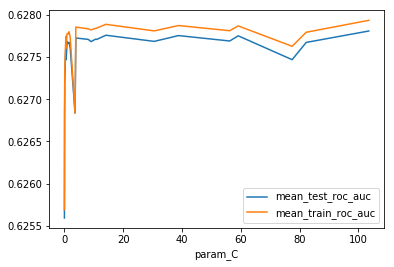

In [117]:
tmp1.plot(x="param_C")

In [118]:
params

{'C': 103.54434758326418}

## Logistic With optimized Hyperparameters 

In [228]:
from sklearn.linear_model import LogisticRegression

bst = LogisticRegression(penalty = 'l1', C=103)

bst.fit(X_train, y_train)

ypred_train = bst.predict_proba(X_train)[:, 1]
ypred_valid = bst.predict_proba(X_valid)[:, 1]
ypred_test = bst.predict_proba(X_test)[:, 1]

print("Train GINI %.3f" % (2*metrics.roc_auc_score(y_train, ypred_train)-1))
print("Valid GINI %.3f" % (2*metrics.roc_auc_score(y_valid, ypred_valid)-1))
print("Test GINI %.3f" % (2*metrics.roc_auc_score(y_test, ypred_test)-1))


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Train GINI 0.256
Valid GINI 0.251
Test GINI 0.222


In [229]:
print("Train GINI %.3f" % (2*metrics.roc_auc_score(y_train, X_train[RISK_SCORE])-1))
print("Valid GINI %.3f" % (2*metrics.roc_auc_score(y_valid, X_valid[RISK_SCORE])-1))
print("Test GINI %.3f" % (2*metrics.roc_auc_score(y_test,X_test[RISK_SCORE])-1))


Train GINI 0.239
Valid GINI 0.232
Test GINI 0.228


In [230]:
df["RISK_RGS_SCORE"] =  bst.predict_proba(df[x_column])[:, 1]

In [231]:
df.to_pickle(os.getcwd()+"\scored_cd_n.pkl")

# Model Evaluation

In [ ]:
# df = pd.read_pickle(os.getcwd()+"\scored_cd_n.pkl")

In [238]:
TIME_DECISION_DATE = "TIME_CREATION_DATE"
FINAL_SCORE = "SEGMENT_SCORE"
RISK_SCORE = "SCORE_APSC_NOV18"
RISK_RGS_SCORE = "RISK_RGS_SCORE"
COMBINED_SCORE = "RISK_RGS_SEGMENT SCORE"
TARGET = "RISK_FSTQPD30"
df["MONTH"] = df[TIME_DECISION_DATE].dt.strftime("%y-%m")

In [239]:
df.head()

,SKP_CREDIT_CASE,TIME_CREATION_DATE,PRODUCT_GOODS_TYPE,PRODUCT_CREDIT_TYPE,AMT_CREDIT,POS_GSPN_V2,...,Goodtohave_SEGMENT,undesirable_SEGMENT,RISK+RGS+SEGMENT SCORE,RISK_RGS_SEGMENT SCORE,SEGMENT_SCORE,RISK_RGS_SCORE
1,220543586,2019-01-01,c_Mob_Tab,STANDARD,7699.0,2.0,...,1,0,0.123763,0.123763,0.083586,0.126657
2,220543587,2019-01-01,c_Mob_Tab,ZERO,7961.0,2.0,...,0,0,0.068949,0.068949,0.074629,0.077657
3,220543588,2019-01-01,c_Mob_Tab,2X0,7500.0,1.0,...,0,0,0.068180,0.068180,0.074629,0.074070
4,220543589,2019-01-01,c_Mob_Tab,STANDARD,6849.0,1.0,...,0,1,0.088972,0.088972,0.097512,0.081953
8,220543598,2019-01-01,c_Mob_Tab,STANDARD,5199.0,2.0,...,0,0,0.071723,0.071723,0.074629,0.080404


# GINI 

### Gini Chart

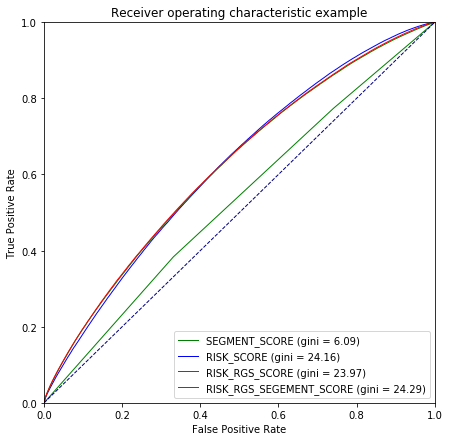

In [241]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

fig = plt.figure(figsize = (7,7))
ax1 = fig.add_subplot(1, 1, 1)

lw = 1

fpr, tpr, thresholds = roc_curve(df[TARGET],df[FINAL_SCORE])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='green', lw=lw, label='SEGMENT_SCORE (gini = %0.2f)' % ((2*roc_auc-1)*100))


fpr, tpr, thresholds = roc_curve(df[TARGET],df[RISK_SCORE])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='blue', lw=lw, label='RISK_SCORE (gini = %0.2f)' % ((2*roc_auc-1)*100))


fpr, tpr, thresholds = roc_curve(df[TARGET],df[RISK_RGS_SCORE])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='green', lw=lw, label='RISK_RGS_SCORE (gini = %0.2f)' % ((2*roc_auc-1)*100))

fpr, tpr, thresholds = roc_curve(df[TARGET],df[COMBINED_SCORE])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='red', lw=lw, label='RISK_RGS_SEGEMENT_SCORE (gini = %0.2f)' % ((2*roc_auc-1)*100))


ax1.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### MOM GINI

In [242]:
gini_dic = {}
for x in df["MONTH"].unique():
    try:
        if "MONTH" not in gini_dic:
            gini_dic["MONTH"] = []
        if FINAL_SCORE not in gini_dic: 
            gini_dic[FINAL_SCORE] = []
        if RISK_SCORE not in gini_dic: 
            gini_dic[RISK_SCORE] = []
        if COMBINED_SCORE not in gini_dic: 
            gini_dic[COMBINED_SCORE] = []
        if RISK_RGS_SCORE not in gini_dic: 
            gini_dic[RISK_RGS_SCORE] = []
        
        gini_dic[FINAL_SCORE].append((2*roc_auc_score(df[df["MONTH"]==x]["RISK_FSTQPD30"],df[df["MONTH"]==x][FINAL_SCORE])-1)*100)
        gini_dic[RISK_SCORE].append((2*roc_auc_score(df[df["MONTH"]==x]["RISK_FSTQPD30"],df[df["MONTH"]==x][RISK_SCORE])-1)*100)
        gini_dic[COMBINED_SCORE].append((2*roc_auc_score(df[df["MONTH"]==x]["RISK_FSTQPD30"],df[df["MONTH"]==x][COMBINED_SCORE])-1)*100)
        gini_dic[RISK_RGS_SCORE].append((2*roc_auc_score(df[df["MONTH"]==x]["RISK_FSTQPD30"],df[df["MONTH"]==x][RISK_RGS_SCORE])-1)*100)
        gini_dic["MONTH"].append(x)
#         for y in PREDICTOR_LIST:
#             if y not in gini_dic:
#                   gini_dic[y] = []
#             gini_dic[y].append(((2*roc_auc_score(df[df["MONTH"]==x]["RISK_FSTQPD30"],df[df["MONTH"]==x][y])-1)*100))
    except: 
        print("ERROR")

gini_df = pd.DataFrame(gini_dic)
gini_df.sort_values(by = "MONTH",inplace = True)
gini_df.reset_index(inplace = True)


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:237: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



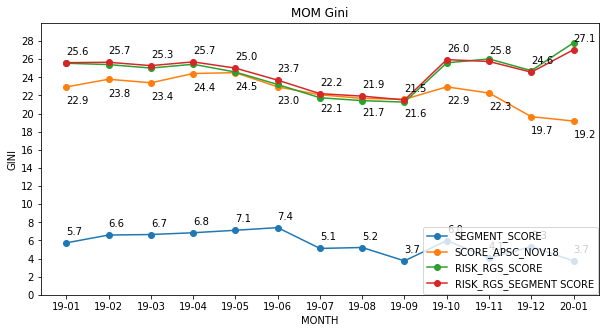

In [243]:
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(gini_df["MONTH"],gini_df[FINAL_SCORE], marker='o', scaley = False, label = FINAL_SCORE)
ax1.plot(gini_df["MONTH"],gini_df[RISK_SCORE], marker='o', scaley = False, label = RISK_SCORE)
ax1.plot(gini_df["MONTH"],gini_df[RISK_RGS_SCORE], marker='o', scaley = False, label = RISK_RGS_SCORE)
ax1.plot(gini_df["MONTH"],gini_df[COMBINED_SCORE], marker='o', scaley = False, label= COMBINED_SCORE)

for i, txt in enumerate(gini_df[FINAL_SCORE]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df[FINAL_SCORE][i]+0.9))
for i, txt in enumerate(gini_df[RISK_SCORE]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df[RISK_SCORE][i]-1.9))
for i, txt in enumerate(gini_df[COMBINED_SCORE]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df[COMBINED_SCORE][i]+0.9))

plt.legend(loc='lower right', borderaxespad=0.1)
plt.ylim(0,30)
plt.ylabel("GINI")
plt.xlabel("MONTH")
plt.yticks(np.arange(0,30,2))
ax1.set_title("MOM Gini")
plt.show()

# Lifts and Gains Chart

In [244]:
def jitter(a_series, noise_reduction=1000000):
    return (np.random.random(len(a_series))*a_series.std()/noise_reduction)-(a_series.std()/(2*noise_reduction))


In [245]:
def lift_and_gain_df(data=None,target=None, prob=None):
    data['target0'] = 1 - data[target]
    data['bucket'] = pd.qcut(data[prob]+jitter(data[prob]), 10)
    grouped = data.groupby('bucket', as_index = False)
    liftstable = pd.DataFrame()
    liftstable['min_prob'] = grouped.min()[prob]
    liftstable['max_prob'] = grouped.max()[prob]
    liftstable['total']   = grouped.count()[target]
    liftstable['bads']   = round(grouped.sum()[target])
    liftstable['goods'] = round(grouped.sum()['target0'])
    liftstable['%base'] = (liftstable.total / data[target].count())
    liftstable = liftstable.sort_values(by="min_prob", ascending=False).reset_index(drop = True)
    liftstable['cum%_base'] = (liftstable.total / data[target].count()).cumsum()
    liftstable['%bads'] = (liftstable['bads'] / data[target].sum())
    liftstable['%goods'] = (liftstable['goods'] / data['target0'].sum())
    liftstable['cum%_bads']=(liftstable['bads'] / data[target].sum()).cumsum()
    liftstable['cum%_goods']=(liftstable['bads'] / data['target0'].sum()).cumsum()

    
    liftstable['lift'] = np.round(liftstable['%bads']/liftstable['%base'] , 3)
    liftstable['cum_lift'] = np.round(liftstable['cum%_bads']/liftstable['cum%_base'] , 3)

    #Formating
    liftstable['%base']= liftstable['%base'].apply('{0:.2%}'.format)
    liftstable['%bads']= liftstable['%bads'].apply('{0:.2%}'.format)
    liftstable['%goods']= liftstable['%goods'].apply('{0:.2%}'.format)
    liftstable['cum%_bads']= liftstable['cum%_bads'].apply('{0:.2%}'.format)
    liftstable['cum%_goods']= liftstable['cum%_goods'].apply('{0:.2%}'.format)
    liftstable['cum%_base'] = liftstable['cum%_base'].apply('{0:.2%}'.format)

    liftstable.index = range(1,11)
    liftstable.index.rename('Decile', inplace=True)
    pd.set_option('display.max_columns', 13)
    return(liftstable)

In [247]:
#cum%_bads is gain_score
combined_score_lift = lift_and_gain_df(data=df,target=TARGET, prob=COMBINED_SCORE)
risk_score_lift = lift_and_gain_df(data=df,target=TARGET, prob=RISK_SCORE)
final_score_lift = lift_and_gain_df(data=df,target=TARGET, prob=FINAL_SCORE)
risk_rgs_score_lift = lift_and_gain_df(data=df,target=TARGET, prob=RISK_RGS_SCORE)

### Cumulative Lift Chart 

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexes\range.py:716: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



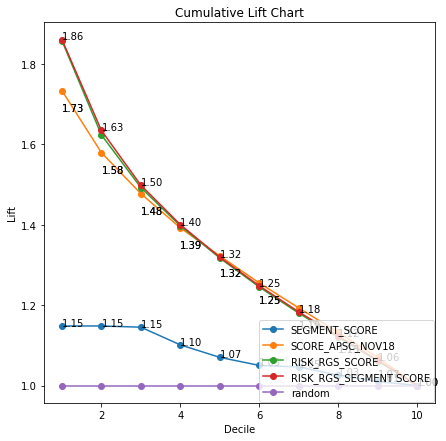

In [248]:
fig = plt.figure(figsize = [7,7])
ax1 = fig.add_subplot(1,1,1)

ax1.plot(combined_score_lift.index,final_score_lift["cum_lift"], label = FINAL_SCORE, marker='o')
for i, txt in enumerate(final_score_lift["cum_lift"]):
    plt.annotate("{:.2f}".format(txt), (risk_score_lift.index[i], final_score_lift["cum_lift"][i+1]))
    
ax1.plot(combined_score_lift.index,risk_score_lift["cum_lift"], label = RISK_SCORE, marker='o')
for i, txt in enumerate(risk_score_lift["cum_lift"]):
    plt.annotate("{:.2f}".format(txt), (risk_score_lift.index[i], risk_score_lift["cum_lift"][i+1]-0.05))

ax1.plot(combined_score_lift.index,risk_rgs_score_lift["cum_lift"], label = RISK_RGS_SCORE, marker='o')
for i, txt in enumerate(risk_score_lift["cum_lift"]):
    plt.annotate("{:.2f}".format(txt), (risk_score_lift.index[i], risk_score_lift["cum_lift"][i+1]-0.05))

    
ax1.plot(combined_score_lift.index,combined_score_lift["cum_lift"], label = COMBINED_SCORE, marker='o')
for i, txt in enumerate(combined_score_lift["cum_lift"]):
    plt.annotate("{:.2f}".format(txt), (combined_score_lift.index[i], combined_score_lift["cum_lift"][i+1]))




ax1.plot(np.arange(1,11,1),[1,1,1,1,1,1,1,1,1,1], label = 'random', marker='o')

plt.legend(loc='lower right', borderaxespad=0.1)
plt.xlabel("Decile")
plt.ylabel("Lift")

ax1.set_title("Cumulative Lift Chart")
plt.show()    


# MOM Gini on Different Targets

In [249]:
df.columns

Index(['SKP_CREDIT_CASE', 'TIME_CREATION_DATE', 'PRODUCT_GOODS_TYPE',
       'PRODUCT_CREDIT_TYPE', 'AMT_CREDIT', 'POS_GSPN_V2', 'SCORE_APSC_NOV18',
       'DECISION_OVERALL', 'RISK_AGRF30', 'RISK_FPD30', 'RISK_FSTQPD30',
       'RISK_FSTQPD60', 'SEGMENT', 'MONTH', '2X0_PRODUCT_CREDIT_TYPE',
       'STANDARD_PRODUCT_CREDIT_TYPE', 'ZERO_PRODUCT_CREDIT_TYPE',
       '1.0_POS_GSPN_V2', '2.0_POS_GSPN_V2', '3.0_POS_GSPN_V2',
       '17.0_POS_GSPN_V2', 'c_Mob_Tab_PRODUCT_GOODS_TYPE',
       'd_CP_PRODUCT_GOODS_TYPE', 'e_HA_PRODUCT_GOODS_TYPE',
       'Desirable_SEGMENT', 'Goodtohave_SEGMENT', 'undesirable_SEGMENT',
       'RISK+RGS+SEGMENT SCORE', 'RISK_RGS_SEGMENT SCORE', 'SEGMENT_SCORE',
       'RISK_RGS_SCORE', 'target0', 'bucket'],
      dtype='object')

In [250]:
TARGET = {
          "RISK_FSTQPD30":150,
          "RISK_FSTQPD60":180,
          "RISK_FPD30":60
         }


In [252]:
import datetime
from sklearn.metrics import roc_auc_score
gini_dic = {}
for x in df["MONTH"].unique():
    for y in TARGET:        
        if "MONTH" not in gini_dic:
            gini_dic["MONTH"] = []
        if "TARGET" not in gini_dic:
            gini_dic["TARGET"] = []
        if FINAL_SCORE not in gini_dic: 
            gini_dic[FINAL_SCORE] = []
        if COMBINED_SCORE not in gini_dic: 
            gini_dic[COMBINED_SCORE] = []
        if RISK_SCORE not in gini_dic: 
            gini_dic[RISK_SCORE] = []
        if RISK_RGS_SCORE not in gini_dic: 
            gini_dic[RISK_RGS_SCORE] = []
        gini_dic["MONTH"].append(x)
        gini_dic["TARGET"].append(y)
        if df[(df["MONTH"]==x)&(df["TIME_CREATION_DATE"]<= datetime.datetime(2020,2,28)-datetime.timedelta(TARGET[y]))].shape[0]>0:

            gini_dic[FINAL_SCORE].append((2*roc_auc_score(df[df["MONTH"]==x][y],df[df["MONTH"]==x][FINAL_SCORE])-1)*100)
            gini_dic[COMBINED_SCORE].append((2*roc_auc_score(df[df["MONTH"]==x][y],df[df["MONTH"]==x][COMBINED_SCORE])-1)*100)
            gini_dic[RISK_SCORE].append((2*roc_auc_score(df[df["MONTH"]==x][y],df[df["MONTH"]==x][RISK_SCORE])-1)*100)
            gini_dic[RISK_RGS_SCORE].append((2*roc_auc_score(df[df["MONTH"]==x][y],df[df["MONTH"]==x][RISK_RGS_SCORE])-1)*100)
                
        else:
            gini_dic[FINAL_SCORE].append(np.nan)
            gini_dic[COMBINED_SCORE].append(np.nan)
            gini_dic[RISK_SCORE].append(np.nan)
            gini_dic[RISK_RGS_SCORE].append(np.nan)
            

    
gini_df = pd.DataFrame(gini_dic)
gini_df

,MONTH,TARGET,SEGMENT_SCORE,RISK_RGS_SEGMENT SCORE,SCORE_APSC_NOV18,RISK_RGS_SCORE
0,19-01,RISK_FSTQPD30,5.734602,25.622963,22.942463,25.557236
1,19-01,RISK_FSTQPD60,6.107727,27.424482,24.426047,27.378530
2,19-01,RISK_FPD30,4.136382,36.714693,28.821864,37.449470
3,19-02,RISK_FSTQPD30,6.597176,25.665629,23.792457,25.409457
4,19-02,RISK_FSTQPD60,6.873106,27.510236,25.246717,27.249239
5,19-02,RISK_FPD30,6.021725,34.542036,28.077033,34.952032
6,19-03,RISK_FSTQPD30,6.652738,25.293603,23.402046,25.025725
7,19-03,RISK_FSTQPD60,7.417698,27.343444,24.830197,26.959117
8,19-03,RISK_FPD30,7.599008,34.822845,29.481304,34.890942
9,19-04,RISK_FSTQPD30,6.848791,25.708281,24.424598,25.445399


In [253]:
gini_df.to_csv(os.getcwd()+"\mom_gini_all_targets.csv")